In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import root_mean_squared_error

from gbnet.models.forecasting import Forecast


urls = [
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_covid.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_multivariate.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_retail_sales.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers1.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers2.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv",
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_yosemite_temps.csv",
]

datasets = pd.DataFrame([
    {
        'name': url.split('/')[-1],
        'data': pd.read_csv(url),
        'url': url,
        'ycol': (
            'y' if not (url.split('/')[-1] == 'example_pedestrians_multivariate.csv')
            else 'location_4'
        )
    }
    for url in urls
])

n_trials = 500
results = []
for _ in range(n_trials):

    seed = 1110011 + _
    dataset = datasets.sample(1, random_state=seed)

    df = dataset['data'].iloc[0].copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = df[dataset['ycol']].copy()

    np.random.seed(seed)
    train_q = np.random.random()
    test_q = np.random.random()
    train_cutoff = df['ds'].quantile(train_q)
    test_cutoff = df[df['ds'] > train_cutoff]['ds'].quantile(test_q)

    train = df[(df['ds'] <= train_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()
    test = df[(df['ds'] > train_cutoff) & (df['ds'] <= test_cutoff) & (df['y'].notnull())].reset_index(drop=True).copy()
        
        
    m = Forecast()
    m.fit(train, train['y'])
    
    test['gbnet_pred'] = m.predict(test)
    
    pm = Prophet()
    pm.fit(train)
    test['prophet_pred'] = pm.predict(test)['yhat']

    sel = test['y'].notnull()
    results.append({
        'name': dataset['name'].iloc[0],
        'train_q': train_q,
        'test_q': test_q,
        'rmse_gbnet': root_mean_squared_error(test[sel]['y'], test[sel]['gbnet_pred']),
        'rmse_prophet': root_mean_squared_error(test[sel]['y'], test[sel]['prophet_pred'])
    })
    print(results[-1])
        


In [2]:
rrr = pd.DataFrame(results)

rrr['gbnet_wins'] = rrr['rmse_gbnet'] < rrr['rmse_prophet']

rrr['gbnet_wins'].mean()

0.742

In [3]:
rrr['gbnet_over_prophet'] = rrr['rmse_gbnet'] / rrr['rmse_prophet']
rrr['prophet_over_gbnet'] = rrr['rmse_prophet'] / rrr['rmse_gbnet']

Text(0.5, 1.0, 'CDF of Losing RMSE / Winning RMSE (up and to the left is better)')

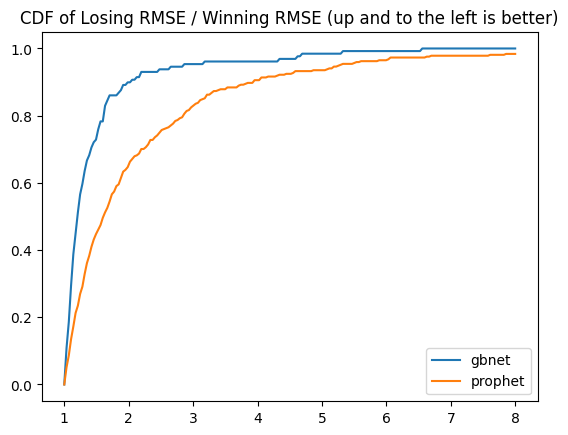

In [7]:
import numpy as np
cdf_grid = np.linspace(1, 8, 200)
gbnet_cdf = []
prophet_cdf = []
for c in cdf_grid:
    gbnet_cdf.append((rrr[~rrr['gbnet_wins']]['gbnet_over_prophet'] <= c).mean())
    prophet_cdf.append((rrr[rrr['gbnet_wins']]['prophet_over_gbnet'] <= c).mean())

plt.plot(cdf_grid, gbnet_cdf, label='gbnet')
plt.plot(cdf_grid, prophet_cdf, label='prophet')
plt.legend()
plt.title('CDF of Losing RMSE / Winning RMSE (up and to the left is better)')

In [5]:
from scipy.stats import ks_2samp, ttest_ind
print(ks_2samp(
    rrr[~rrr['gbnet_wins']]['gbnet_over_prophet'],
    rrr[rrr['gbnet_wins']]['prophet_over_gbnet'],
))

print(ttest_ind(
    rrr[~rrr['gbnet_wins']]['gbnet_over_prophet'],
    rrr[rrr['gbnet_wins']]['prophet_over_gbnet'],
))

KstestResult(statistic=0.3273783405420088, pvalue=1.3191525457323801e-09, statistic_location=1.3232986477251762, statistic_sign=1)
TtestResult(statistic=-4.5573767590652885, pvalue=6.524233629215753e-06, df=498.0)
